In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import calendar
plt.style.use('ggplot')

In [5]:
# load all of the audio data 
fp = r"..\Data\csv\training_data.csv"
df = pd.read_csv(fp).drop("Unnamed: 0", axis = 1)
df.head()


,path,filename,full_duration,duration_limit,padding,missing_samples,spectrogram_min,spectrogram_max,mel_spectrogram_min,mel_spectrogram_max,mfcc_min,mfcc_max,spectrogram_path,mel_spectrogram_path,mfcc_path
0,E:\Sample library\2021\[WU] Hat - Bowl.wav,[WU] Hat - Bowl.wav,0.0,8,True,350879,-49.120300,30.879700,-74.402550,5.597448,-651.845215,93.570595,E:\Documents\My Projects\Filtr\Data\audio_vect...,E:\Documents\My Projects\Filtr\Data\audio_vect...,E:\Documents\My Projects\Filtr\Data\audio_vect...
1,E:\Sample library\2021\[WU] Clap - Twist.wav,[WU] Clap - Twist.wav,0.0,8,True,348991,-37.832912,42.167088,-57.490067,22.509935,-510.737946,132.957932,E:\Documents\My Projects\Filtr\Data\audio_vect...,E:\Documents\My Projects\Filtr\Data\audio_vect...,E:\Documents\My Projects\Filtr\Data\audio_vect...
2,E:\Sample library\2021\[WU] Perc (30).wav,[WU] Perc (30).wav,0.0,8,True,351196,-53.774376,26.225622,-74.140091,5.859912,-667.241821,34.692505,E:\Documents\My Projects\Filtr\Data\audio_vect...,E:\Documents\My Projects\Filtr\Data\audio_vect...,E:\Documents\My Projects\Filtr\Data\audio_vect...
3,E:\Sample library\2021\[WU] Perc (22).wav,[WU] Perc (22).wav,0.0,8,True,349933,-39.270737,40.729263,-59.228420,20.771580,-481.627411,134.089661,E:\Documents\My Projects\Filtr\Data\audio_vect...,E:\Documents\My Projects\Filtr\Data\audio_vect...,E:\Documents\My Projects\Filtr\Data\audio_vect...
4,E:\Sample library\2021\[WU] Open Hat - Tech.wav,[WU] Open Hat - Tech.wav,0.0,8,True,335821,-46.321472,33.678528,-71.892166,8.107837,-608.958801,87.468155,E:\Documents\My Projects\Filtr\Data\audio_vect...,E:\Documents\My Projects\Filtr\Data\audio_vect...,E:\Documents\My Projects\Filtr\Data\audio_vect...


In [6]:
# convert the entire column to lowercase and remove .wav from all samples
df['path'] = df['path'].apply(lambda x: x.lower()).str.replace(".wav","")
df.head() 

,path,filename,full_duration,duration_limit,padding,missing_samples,spectrogram_min,spectrogram_max,mel_spectrogram_min,mel_spectrogram_max,mfcc_min,mfcc_max,spectrogram_path,mel_spectrogram_path,mfcc_path
0,e:\sample library\2021\[wu] hat - bowl,[WU] Hat - Bowl.wav,0.0,8,True,350879,-49.120300,30.879700,-74.402550,5.597448,-651.845215,93.570595,E:\Documents\My Projects\Filtr\Data\audio_vect...,E:\Documents\My Projects\Filtr\Data\audio_vect...,E:\Documents\My Projects\Filtr\Data\audio_vect...
1,e:\sample library\2021\[wu] clap - twist,[WU] Clap - Twist.wav,0.0,8,True,348991,-37.832912,42.167088,-57.490067,22.509935,-510.737946,132.957932,E:\Documents\My Projects\Filtr\Data\audio_vect...,E:\Documents\My Projects\Filtr\Data\audio_vect...,E:\Documents\My Projects\Filtr\Data\audio_vect...
2,e:\sample library\2021\[wu] perc (30),[WU] Perc (30).wav,0.0,8,True,351196,-53.774376,26.225622,-74.140091,5.859912,-667.241821,34.692505,E:\Documents\My Projects\Filtr\Data\audio_vect...,E:\Documents\My Projects\Filtr\Data\audio_vect...,E:\Documents\My Projects\Filtr\Data\audio_vect...
3,e:\sample library\2021\[wu] perc (22),[WU] Perc (22).wav,0.0,8,True,349933,-39.270737,40.729263,-59.228420,20.771580,-481.627411,134.089661,E:\Documents\My Projects\Filtr\Data\audio_vect...,E:\Documents\My Projects\Filtr\Data\audio_vect...,E:\Documents\My Projects\Filtr\Data\audio_vect...
4,e:\sample library\2021\[wu] open hat - tech,[WU] Open Hat - Tech.wav,0.0,8,True,335821,-46.321472,33.678528,-71.892166,8.107837,-608.958801,87.468155,E:\Documents\My Projects\Filtr\Data\audio_vect...,E:\Documents\My Projects\Filtr\Data\audio_vect...,E:\Documents\My Projects\Filtr\Data\audio_vect...


In [128]:
def create_pattern(words):
    ''' used to create single string that can be used by the 
        .str.contains() method to find rows using a list of words.'''

    # make sure words is a list and if not convert it to one
    words = words.split() if isinstance(words, str) else words
    if len(words) <= 1:
        return "".join(words)
    else:
        return "|".join(words)

# return all of the data that contains the pattern
def contains(words, frame):
    # make sure a dataframe is being passed
    assert isinstance(frame, pd.core.frame.DataFrame), f"Frame parameter must be a pandas dataframe, not {type(frame)}"
    frame = frame.copy()
    # combine multiple words into a single pattern (if applicable)
    pattern = create_pattern(words)
    # filter the dataframe to return a new series with all of the rows that contain the pattern
    match_mask = frame['path'].str.contains(pattern)
    matched_frame = frame[match_mask]['path'].apply(lambda x: "" if (len(x) == len(pattern) or len(x) == len(pattern) + 1) else x)
    return matched_frame

def trim_path_directories(path: str) -> list:
    ''' removes the first 3 directories from the path if the file is in the e: drive 
        and removes the first 4 directories from the path if the file is in the d: drive '''
    
    # returns the path split by directory 
    directories = path.split("\\")
    drive = directories[0]
    # print(drive)
    if drive == "d:":
        return directories[:-3]
    elif drive == "e:":
        return directories[:-3]

def clean(docs: list):
    ''' cleans a document and return tokens as a string'''
    # convert the list into a string
    doc = " ".join(docs)
    # replace dashes with empty string
    doc = doc.replace("-", "")
    doc = doc.replace("_", " ")
    # remove punctuation 
    table = str.maketrans(dict.fromkeys(string.punctuation))
    doc = doc.translate(table)
    # remove numbers
    remove_digits = str.maketrans(dict.fromkeys("12345679"))
    doc = doc.translate(remove_digits)
    # create tokens
    doc = doc.split()
    # remove stop words and words shorter than 3 characters
    stops = nltk.corpus.stopwords.words("english")
    extra = ['sound', 'sounds', 'file', 'files', 'library', 'spring', 'summer',
            'winter', 'packs', 'essential', 'sample', 'labeled', 'project', 'cubase',
            'flp', 'ableton', 'stems', 'beat', 'beats', 'vol', 'kit', 'kits', 'bundle', 'sample',
            'samples', 'cpa', 'ilex', 'original', 'volume', 'store', 'pack', 'splice', 'collection',
             'sessions', 'processed', 'package', 'unmüte', 'samplified', 'cymatics', 'christmas', 'people', 'reel',
             'loop', 'loops', 'loopmasters', 'capsun', 'squadpack']
    extra.extend(month_names())
    extra.extend(stops)

    stops = set(extra)
    doc = [word for word in doc if word not in stops and len(word) > 2]
    # get only the unique tokens
    doc = set(doc)
    # remove 's' at the end of words
    # doc = [word[:-1] for word in doc if word.endswith('s')]
    # stem words
    # stemmer = nltk.stem.PorterStemmer()
    # doc = [stemmer.stem(word) for word in doc]
    # return as a string
    doc = " ".join(doc)
    return doc

def get_document(path: str):
    ''' takes in a path and returns it as a cleaned document (strings) '''

    # cleanup the text used to represent the directories
    directories = trim_path_directories(path)
    document = clean(directories)
    return document

def vectorize(documents: list, algorithm = "count", **kwargs):
    ''' takes in a list of documents and vectorizes them based on the algorithm '''
    algorithm = algorithm.lower()

    # optional keyword arguments
    binary = kwargs.get("binary", False)
    ngram_range = kwargs.get("ngram_range", (1, 1))
    max_df = kwargs.get("max_df", 1.0)
    min_df = kwargs.get("min_df", 1)


    # make sure a valid algorithm is being used
    assert (algorithm == 'count' or algorithm == "tfidf"), f"Algorithm must be 'count' or 'tfidf' not: {algorithm}"

    # sets up each vectorizer algorithm
    if algorithm == "tfidf":
        vectorizer = TfidfVectorizer(binary = binary,
                                     ngram_range = ngram_range,
                                     max_df = max_df,
                                     min_df = min_df)
    else:
        vectorizer = CountVectorizer(binary=binary,
                                     ngram_range=ngram_range,
                                     max_df=max_df,
                                     min_df=min_df)

    dtm = vectorizer.fit_transform(documents)
    return vectorizer, dtm

def get_word_probabilities(documents: list, normalize = True) -> list:
    ''' gets the probabilities of a word appearing given a filter word '''
    counter = Counter()
    # add each of the words in all documents to the counter
    # counter.update([doc.split() for doc in documents])
    for document in documents:
        document = document.split() 
        counter.update(document)
    
    if normalize:
        counter = [(word, counter[word] / len(documents) * 100.0) for word in counter]
    else:
        counter = [(word, counter[word]) for word in counter]
        
    return counter
    
    
def by_values(values):
    return values[1]


def month_names():
    return [month.lower() for month in calendar.month_name][1:]


def get_xy(list_of_tuples, limit=20):
    ''' takes in a list of words and their frequencies and returns them as labels and count lists '''
    labels = []
    occurences = []
    for label, frequency in list_of_tuples[:limit]:
        labels.append(label)
        occurences.append(frequency)

    return labels, occurences


def create_barchart(x, y, word=""):
    ''' creates a horizontal barchart to display frequency data '''

    # plt.figure(figsize=(30, 105))
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.barh(x, y, align="center")

    ax.set_yticks(np.arange(len(y)))
    # ax.set_yticklabels(people)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Frequency')
    ax.set_title(f'Word frequencies given {word}')

    plt.show()


In [131]:
%matplotlib inline

search = 'soul kick'
data = contains(search, df)
data = data.apply(lambda x: get_document(x))
print(f"Shape: {data.shape}")

# vector = vectorize(data.tolist(), algorithm = 'tfidf')
# Counter(vector.vocabulary_).most_common()
# vector.get_feature_names()
# vector.get_params()



Shape: (6862,)


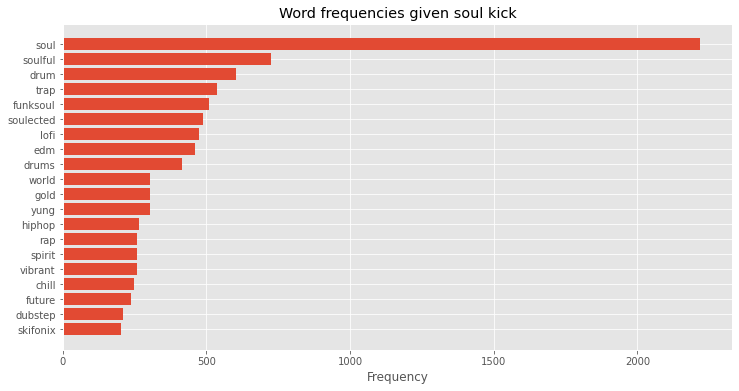

In [132]:

values = get_word_probabilities(data.tolist(), False)
values.sort(key = by_values, reverse = True)
# values[:20]

labels, occurences = get_xy(values)
create_barchart(labels, occurences, search)


In [105]:
values[:100]

[('samplified', 976),
 ('people', 870),
 ('reel', 870),
 ('loopmasters', 870),
 ('ful', 724),
 ('unmüte', 568),
 ('christmas', 541),
 ('funk', 510),
 ('squadpack', 487),
 ('ected', 487),
 ('edm', 459),
 ('trap', 423),
 ('loops', 385),
 ('world', 304),
 ('gold', 304),
 ('capsun', 304),
 ('yung', 304),
 ('hiphop', 263),
 ('vibrant', 258),
 ('rap', 258),
 ('spirit', 258),
 ('lofi', 255),
 ('future', 176),
 ('love', 169),
 ('neo', 167),
 ('experiment', 167),
 ('vocals', 166),
 ('originals', 165),
 ('skifonix', 149),
 ('skusm00flr', 137),
 ('monte', 127),
 ('booker', 127),
 ('chill', 126),
 ('cali', 126),
 ('cloudchord', 118),
 ('dropgun', 118),
 ('guitar', 118),
 ('rnb', 116),
 ('oneshots', 110),
 ('melodic', 110),
 ('laniakea', 110),
 ('amin', 102),
 ('perc', 101),
 ('drums', 101),
 ('dmin', 95),
 ('cmin', 82),
 ('surplus', 55),
 ('swoope', 52),
 ('bmin', 46),
 ('gmin', 44),
 ('emin', 37),
 ('tru', 30),
 ('midi', 30),
 ('progressions', 30),
 ('urban', 30),
 ('chord', 30),
 ('unmute', 30),

In [59]:
stops = nltk.corpus.stopwords.words("english")
extra = ['sound', 'sounds', 'file', 'files', 'library', 'spring', 'summer', 
        'winter', 'packs', 'essential', 'sample', 'labeled', 'project', 'cubase', 
        'flp', 'ableton', 'stems', 'beat', 'beats', 'vol', 'kit', 'kits', 'bundle']
extra.extend(month_names())
extra.extend(stops)
print(extra)

['sound', 'sounds', 'file', 'files', 'library', 'spring', 'summer', 'winter', 'packs', 'essential', 'sample', 'labeled', 'project', 'cubase', 'flp', 'ableton', 'stems', 'beat', 'beats', 'vol', 'kit', 'kits', 'bundle', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through',

In [51]:


month_names()

['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']